In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install pykalman


In [11]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
data= pd.read_csv('/content/drive/MyDrive/train01.csv')
data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750011,Innovators,Episode 50,34.44,Technology,47.55,Thursday,Night,46.03,0,Positive
1,750014,Comedy Corner,Episode 77,71.15,Comedy,70.60,Thursday,Morning,32.70,3,Positive
2,750032,Tech Talks,Episode 96,20.87,Technology,49.83,Thursday,Morning,88.30,2,Positive
3,750037,Mind & Body,Episode 47,49.64,Health,96.03,Thursday,Morning,17.81,0,Positive
4,750046,Sports Central,Episode 18,23.75,Sports,56.83,Thursday,Night,NaN,3,Positive


In [13]:
thursday_data = data[data['Publication_Day'] == 'Thursday'].copy()
print(f"Số bản ghi thứ 5: {len(thursday_data)}")

Số bản ghi thứ 5: 64757


In [15]:
# 2. Xử lý giá trị thiếu (rõ ràng hơn)
for col in ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads']:
    thursday_data[col] = thursday_data[col].fillna(thursday_data[col].mean())
thursday_data['Guest_Popularity_percentage'] = thursday_data['Guest_Popularity_percentage'].fillna(0)

In [16]:
# 3. Mã hóa thời gian phát hành
le = LabelEncoder()
thursday_data['Publication_Time_Encoded'] = le.fit_transform(thursday_data['Publication_Time'])

In [17]:
# 4. Làm mượt bằng bộ lọc Kalman (Local Level Model)
kf = KalmanFilter(
    transition_matrices=np.array([[1]]),
    observation_matrices=np.array([[1]]),
    transition_covariance=np.array([[0.1]]),
    observation_covariance=np.array([[1.0]]),
    initial_state_mean=np.array([0]),
    initial_state_covariance=np.array([[1]])
)
state_means, _ = kf.filter(thursday_data['Episode_Length_minutes'].values)
thursday_data['Smoothed_Episode_Length'] = state_means.flatten()

In [18]:
# 5. Chuẩn bị dữ liệu cho mô hình học máy
features = ['Smoothed_Episode_Length', 'Host_Popularity_percentage',
            'Guest_Popularity_percentage', 'Number_of_Ads', 'Publication_Time_Encoded']
X = thursday_data[features]
y = thursday_data['Episode_Length_minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

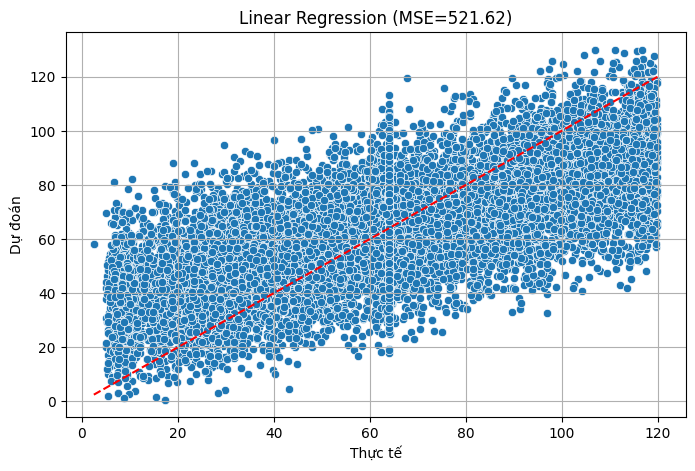

In [19]:
# === Mô hình 1: Linear Regression ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title(f'Linear Regression (MSE={mse_lr:.2f})')
plt.grid(True)
plt.show()


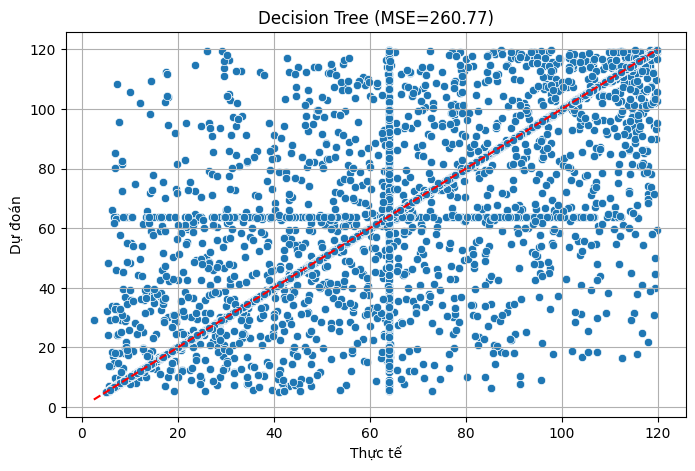

In [20]:
# === Mô hình 2: Decision Tree ===
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_dt)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title(f'Decision Tree (MSE={mse_dt:.2f})')
plt.grid(True)
plt.show()

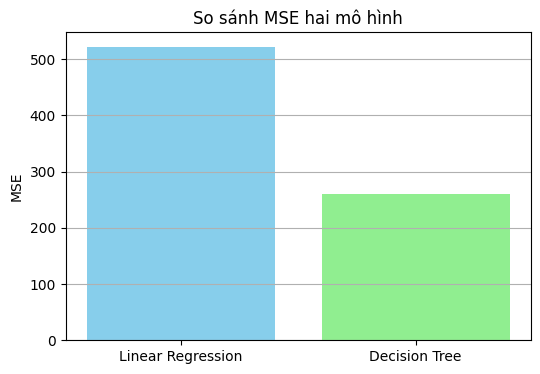

In [21]:
# === So sánh MSE ===
plt.figure(figsize=(6,4))
plt.bar(['Linear Regression', 'Decision Tree'], [mse_lr, mse_dt], color=['skyblue', 'lightgreen'])
plt.ylabel('MSE')
plt.title('So sánh MSE hai mô hình')
plt.grid(axis='y')
plt.show()

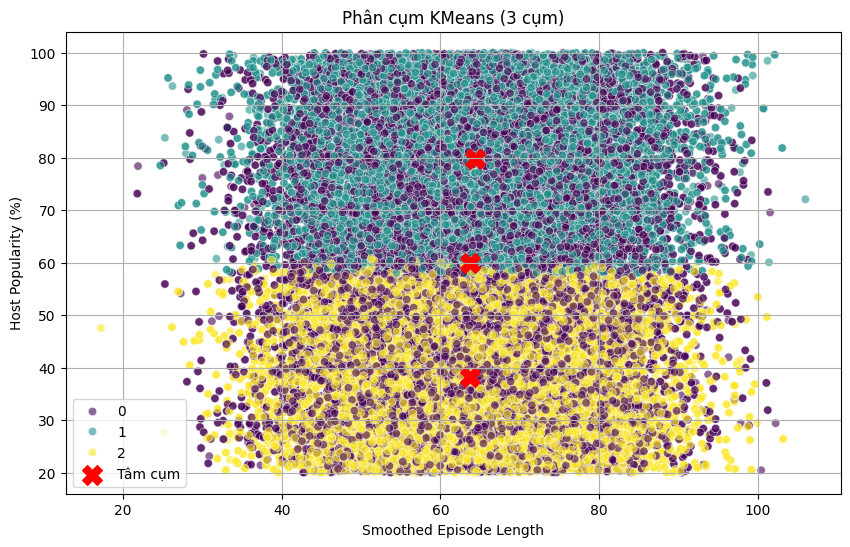

In [23]:
# === Mô hình 3: KMeans ===
kmeans = KMeans(n_clusters=3, random_state=42)
thursday_data['Cluster'] = kmeans.fit_predict(X)

# Trực quan hóa phân cụm
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Smoothed_Episode_Length',
    y='Host_Popularity_percentage',
    hue='Cluster',
    palette='viridis',
    data=thursday_data,
    alpha=0.6
)
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', s=200, marker='X', label='Tâm cụm'
)
plt.xlabel("Smoothed Episode Length")
plt.ylabel("Host Popularity (%)")
plt.title("Phân cụm KMeans (3 cụm)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Tóm tắt cụm
cluster_summary = thursday_data.groupby('Cluster')[features].mean()
print("\n=== Tóm tắt từng cụm ===")
print(cluster_summary.round(2))


=== Tóm tắt từng cụm ===
         Smoothed_Episode_Length  Host_Popularity_percentage  \
Cluster                                                        
0                          63.72                       60.04   
1                          64.39                       79.69   
2                          63.73                       38.19   

         Guest_Popularity_percentage  Number_of_Ads  Publication_Time_Encoded  
Cluster                                                                        
0                              73.24           1.33                      1.54  
1                              14.87           1.35                      1.53  
2                              17.94           1.36                      1.54  


In [25]:
# === Tổng kết hiệu suất mô hình ===
print("\n=== Tổng kết MSE ===")
print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Decision Tree MSE: {mse_dt:.4f}")
if mse_lr < mse_dt:
    print("Linear Regression tốt hơn (MSE thấp hơn).")
else:
    print("Decision Tree tốt hơn (MSE thấp hơn).")


=== Tổng kết MSE ===
Linear Regression MSE: 521.6168
Decision Tree MSE: 260.7740
Decision Tree tốt hơn (MSE thấp hơn).
